In [1]:
# Import necessary packages
from __future__ import print_function
%matplotlib inline 
# make plots show in ipython notebook

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix

import numpy as np
import pandas as pd
import pylab
import itertools
import string
import os, sys
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
# Initialize global variables
vectorizer = None
tokens = None # List of tokens
stemmer = PorterStemmer() # generalize all words
pMc = None # p(t|Mc)
pMd = None # p(t|Md)
if sys.version_info.major == 2:
    punct_table = string.maketrans('','')
else:
    punct_table = str.maketrans('','', string.punctuation)

In [3]:
# Load two files
target_file = pd.read_table("target_collection", compression = None, header = 0, sep = '\t')
query_file = pd.read_table("queries_val", compression = None, header = 0, sep = '\t')

In [4]:
# Check loaded two files
target_file.head()

,sent_id,img_id,txt_caption
0,0,EiS5L2wmSbJq8Y3u,A picture of a man standing next to a horse on...
1,1,P5xKs0Q1QB8vbgVH,A man is holding up a fish.
2,2,u5EXhe28CW4XySoT,There is man motioning with his hands in front...
3,3,cpmk_ry7TG3lTvlX,A man wearing a green coat holding something i...
4,4,IawGgdRJoTmZSYEs,Chairs in a circle in front of some books.


In [5]:
query_file.head()

,sent_id,img_id,txt_caption
0,17984,CbnA_e6AW6U7Ycoa,Two people in a group of four are holding awar...
1,17985,XBZPztvt67qkMUdI,A man in a white shirt sitting by the table an...
2,17986,PaqtOaYmQmXkqW2i,A woman in a red dress is posing with an axe.
3,17987,IPcFtNL-7EQ6Z0yu,Two soccer plays stand next to each other with...
4,17988,IMAD0sq2Fz7HpSgX,A white and yellow train goes along the track.


In [6]:
def cleantext(text):
    """Clean string from punctuation and capitals."""
    lowers = text.lower()
    if sys.version_info.major == 2:
        no_punctuation = lowers.translate(punct_table, string.punctuation)
    else:
        no_punctuation = lowers.translate(punct_table)
    return no_punctuation

In [7]:
def tokenize(text):
    """Transform string to list of stemmed tokens."""
    tokens = nltk.word_tokenize(text)
    stemmed = (stemmer.stem(token) for token in tokens if token not in stopwords.words('english')) # remove stop words
    return stemmed

In [8]:
def getUnigram():
    """Get unigram language model."""
    global vectorizer
    global tokens
    global pMd
    global pMc
    
    texts_content = []
    for row in target_file.itertuples():
        texts_content.append(cleantext(row[3]))

    vectorizer = CountVectorizer(tokenizer=tokenize)
    texts_counts = vectorizer.fit_transform(texts_content) # TF for tokens in collection and documents
    tokens = vectorizer.get_feature_names()
    dim_texts_counts = "The dimension of words matrix is: " + str(np.shape(texts_counts))
    logger.info(dim_texts_counts)
    pMc = texts_counts.sum(0) / float(texts_counts.sum())
    logger.info(np.shape(pMc))
    pMd = csr_matrix(texts_counts.multiply(1.0/texts_counts.sum(1)))
    logger.info(np.shape(pMd))

In [9]:
getUnigram()

INFO:root:The dimension of words matrix is: (17784, 5059)
INFO:root:(1L, 5059L)
INFO:root:(17784, 5059)


In [10]:
def querySimilarity(query, lam):
    """Rank all documents for a query"""
    query_tokens = tokenize(cleantext(query))
    query_tokens_index = [tokens.index(i) for i in query_tokens if i in tokens] # get positions of all tokens
    if len(query_tokens_index) < 1: # this query share no word with all documents
        return None
    sim_score = sum([np.log(pMd.getcol(t).multiply(lam).toarray() + (1 - lam) * pMc[0, t]) for t in query_tokens_index])
    best0 = np.argsort(-sim_score, axis=0) # sort by similarity score decreasingly
    best = [i[0] for i in best0]
    sim_score_best = [i[0] for i in sim_score[best]]
    return [best, sim_score_best]

In [13]:
def searchPairs4Test(outFileName, testFileName, lam):
    """Rank targets for all queries in test file and write the result in outFile"""
    outFile = open(outFileName, 'w')
    test_file = pd.read_table(testFileName, compression = None, header = 0, sep = '\t') # read test file
    for row in test_file.itertuples(): # scan over test file
        query_id, query = row[1], row[2]
        best = querySimilarity(query, lam)
        if best:
            target_key = target_file['sent_id'][best[0][:1000]]  # get sent_id for first 1000 targets
            d = {'query': [query_id]*1000, 'target': target_key, 'score':best[1][:1000]}
            d = pd.DataFrame(d)
            for row1 in d.itertuples():
                toWrite = str(row1[1]) + " 0 " + str(row1[3]) + " 0 " + str(row1[2]) + ' 0\n'
                outFile.write(toWrite)
    outFile.close()

In [14]:
searchPairs4Test('testUnigramResult.txt', 'queries_test_4stp.txt', 0.5)

In [11]:
def getAveragePrecision(query_img_id, best, cutoff):
    """compute AP for a query for recall@cutoff"""
    if not best: # this query has no match
        return 0.0
    else:
        tp_series = np.where(np.asarray([target_file['img_id'][x] for x in best[:cutoff]]) == query_img_id)[0]
        tp_tpfp = [(i_no + 1.0)/(i + 1.0) for i_no, i in enumerate(tp_series)]# precision = (tp/(tp+fp))
        tpfn = len(np.where(target_file['img_id'] == query_img_id)[0]) #tp+fn
        averPrec = sum(tp_tpfp)/tpfn
        return averPrec

In [12]:
def precAndRec(query_img_id, best):
    """compute precision-recall curve for a query"""
    if not best: # this query has no match
        return None
    else:
        tp_series = np.where(np.array([target_file['img_id'][x] for x in best]) == query_img_id)[0]
        tp_tpfp = [(i_no + 1.0)/(i + 1.0) for i_no, i in enumerate(tp_series)]# precision = (tp/(tp+fp))
        tpfn = len(np.where(target_file['img_id'] == query_img_id)[0]) #tp+fn， denominator for recall
        tmp = 0
        i = 0
        precRecall_arr = [0.0] * 11
        # computation of precision based on 11 standard recall levels
        for tmp in range(len(tp_tpfp)):
            while (i/10.0) <= ((tmp + 1.0) / tpfn):
                precRecall_arr[i] = tp_tpfp[tmp]
                i += 1
        return np.array(precRecall_arr)
        

In [13]:
def meanResult(lam, graph = False):
    """loop over all queries and calculate average result for AP and precision-recall"""
    sum_averagePrecision = []
    sum_precision = np.array([0.0] * 11)
    for row in query_file.itertuples():
        query, query_img_id = row[3], row[2]
        best = querySimilarity(query, lam)
        sum_averagePrecision.append(getAveragePrecision(query_img_id, best[0], 1000))
        if graph:
            prec = precAndRec(query_img_id, best[0])
            sum_precision += prec
    
    meanAP = np.mean(sum_averagePrecision)
    print("Mean Average Precision of Unigram Language Model is: ", str(meanAP))
    if graph:
        pylab.plot(np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), sum_precision / 1000)
        pylab.xlabel('recall')
        pylab.ylabel('precision')
        pylab.title('Unigram Language Model')
    

In [41]:
# change the values of lambda to select a best one. based on this result, the best lambda is 0.5
for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    meanResult(i)

Mean Average Precision of Unigram Language Model is:  0.272491654847
Mean Average Precision of Unigram Language Model is:  0.282002947782
Mean Average Precision of Unigram Language Model is:  0.285421648072
Mean Average Precision of Unigram Language Model is:  0.287092794903
Mean Average Precision of Unigram Language Model is:  0.287347170186
Mean Average Precision of Unigram Language Model is:  0.287127213849
Mean Average Precision of Unigram Language Model is:  0.285418341939
Mean Average Precision of Unigram Language Model is:  0.283937878638


Mean Average Precision of Unigram Language Model is:  0.287347170186


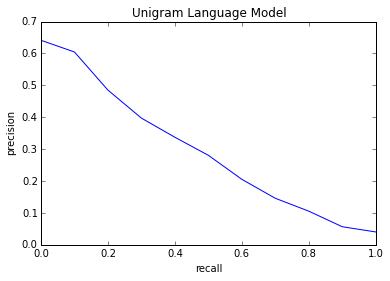

In [14]:
meanResult(lam = 0.5, graph = True)

In [49]:
def searchPairs(outFileName, lam):
    outFile = open(outFileName, 'w')
    for row in query_file.itertuples():
        query, query_img_id = row[3], row[2]
        best = querySimilarity(query, lam)   # best[0] is the row number for document, best[1] is the similarity score
        if best:
            target_doc = target_file['txt_caption'][best[0][:1000]]
            target_key = target_file['img_id'][best[0][:1000]]
            d = {'query': [query]*1000, 'target': target_doc, 'match': [query_img_id]*1000 == target_key, 'score':best[1][:1000]}
            d = pd.DataFrame(d)
            for row1 in d.itertuples():
                toWrite = str(row1[1]) + '\t' + row1[2] + '\t' + row1[4] + '\t' + str(row1[3]) + '\n'
                outFile.write(toWrite)
    outFile.close()    

In [50]:
searchPairs('unigramResult.txt', lam) # if you want to save all query-document-match-similarity results, run this line.

In [18]:
test_queries = ["Two people in a group of four are holding awards as they pose for a picture.",\
                "A woman in a red dress is posing with an axe.",\
                "Two soccer plays stand next to each other with soccer balls in front of them."]
test_keys = ["CbnA_e6AW6U7Ycoa", "PaqtOaYmQmXkqW2i", "IPcFtNL-7EQ6Z0yu"]

In [45]:
def testExamples(query, key, lam):
    best = querySimilarity(query, lam)
    target_doc = target_file['txt_caption'][best[0][:1000]]
    target_key = target_file['img_id'][best[0][:1000]]
    d = {'target':target_doc, 'match':[key]*1000 == target_key, 'score':best[1][:1000]}
    d = pd.DataFrame(d)
    for i in range(20):
        print(d['match'].iloc[i])
        print(d['score'].iloc[i])
        print(query)
        print(d['target'].iloc[i])
        print()
    return d

In [46]:
test1 = testExamples(test_queries[0], test_keys[0], 0.5)

False
-28.9708953301
Two people in a group of four are holding awards as they pose for a picture.
A group of people where all but two of the people are holding awards.

False
-31.7287056644
Two people in a group of four are holding awards as they pose for a picture.
Two people holding up an award as people clap.

False
-31.9004595325
Two people in a group of four are holding awards as they pose for a picture.
A group of people holding a bunch of different awards.

True
-31.9004595325
Two people in a group of four are holding awards as they pose for a picture.
A group of people are standing together and holding awards.

True
-32.2081595919
Two people in a group of four are holding awards as they pose for a picture.
Four people are holding awards and standing in a line in front of a blue wall.

False
-32.5390621829
Two people in a group of four are holding awards as they pose for a picture.
Four people posing for a picture.

False
-32.9493501367
Two people in a group of four are holding 

In [47]:
test2 = testExamples(test_queries[1], test_keys[1], 0.5)

True
-17.6152163062
A woman in a red dress is posing with an axe.
A woman with long dark hair in a red dress sits next to rubble holding an axe.

True
-17.963899021
A woman in a red dress is posing with an axe.
There is a woman in red sitting with an axe in her hand.

False
-19.0079328538
A woman in a red dress is posing with an axe.
A red haired woman in a dress is posing.

False
-19.0079328538
A woman in a red dress is posing with an axe.
A woman in a red dress poses for a picture.

True
-19.3743883383
A woman in a red dress is posing with an axe.
A woman with long hair and wearing a red dress sitting on a wooden platform with her hand resting on the top of a long-handled axe and chopped pieces of wood at her feet.

False
-19.6966250321
A woman in a red dress is posing with an axe.
A picture of a woman in a red dress posing for the camera.

False
-19.6966250321
A woman in a red dress is posing with an axe.
A woman in a dress and heels posing on a red carpet.

True
-19.9150815495
A wo

In [48]:
test3 = testExamples(test_queries[2], test_keys[2], 0.5)

True
-28.7349645556
Two soccer plays stand next to each other with soccer balls in front of them.
Two men are standing with soccer balls.

True
-30.2955249455
Two soccer plays stand next to each other with soccer balls in front of them.
Two soccer players in orange and black striped t-shirts, stand waiting in front of some balls.

False
-31.1816705479
Two soccer plays stand next to each other with soccer balls in front of them.
Two soccer players battle for the ball.

False
-31.8922195769
Two soccer plays stand next to each other with soccer balls in front of them.
Two opposing soccer players going for the ball.

False
-32.5834469273
Two soccer plays stand next to each other with soccer balls in front of them.
Two men play soccer inside.

False
-32.5834469273
Two soccer plays stand next to each other with soccer balls in front of them.
A picture of two men playing soccer.

False
-32.5834469273
Two soccer plays stand next to each other with soccer balls in front of them.
Two people play